In [67]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
tickers = ['MSFT', 'AMZN', 'FB', 'NVDA', 'AAPL', 'GLD', 'BND', 'V', 'NEE', 'LMT', 'COST']

In [69]:
def get_stock_returns(tickers, interval, time_period):
    '''
    Valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
    '''
    stock_returns = list()
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        print('Retrieve stock price for: ', ticker)
        stock_returns.append(stock.history(interval=interval, period=time_period).Close.dropna().pct_change().fillna(0))
    return np.array(stock_returns)

def data_process(returns, normalizing_factor=252):
    '''
    Normalizing factor by default adjusts to the annualized data
    '''
    covariance_matrix = np.cov(returns) * normalizing_factor
    expected_returns = np.mean(returns, axis=1) * normalizing_factor
    return covariance_matrix, expected_returns

In [70]:
stock_returns = get_stock_returns(tickers, interval='1mo', time_period='3y')
Q, expected_returns = data_process(stock_returns, normalizing_factor=1)

Retrieve stock price for:  MSFT
Retrieve stock price for:  AMZN
Retrieve stock price for:  FB
Retrieve stock price for:  NVDA
Retrieve stock price for:  AAPL
Retrieve stock price for:  GLD
Retrieve stock price for:  BND
Retrieve stock price for:  V
Retrieve stock price for:  NEE
Retrieve stock price for:  LMT
Retrieve stock price for:  COST


## Draw Efficneit Frontier

In [71]:
max_var = np.var(stock_returns, axis=1).max()
min_var = np.var(stock_returns, axis=1).min()
inc_var = (max_var - min_var) / 100

# Initialize the portfolio variance to be the minimum possible variance as starting point of the frontier
portfolio_variance = min_var
x = list()
y = list()

In [72]:
def objective(w):
    return -1 * (np.dot(expected_returns, w))

def constraint_1(w):
    return w.sum() - 1.0

def constraint_2(w):
    return portfolio_variance - np.dot(np.dot(w, Q), w)

w0 = np.random.uniform(high=1 / len(tickers), size=len(tickers))
bounds = ([(0.0, 1.0)] * len(tickers))
cons = [{'type': 'eq', 'fun': constraint_1},
        {'type': 'ineq', 'fun': constraint_2}]

opti_results = list()

In [73]:
for i in range(100):
    sol = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
    x.append(portfolio_variance)
    y.append(-1 * sol.fun)
    opti_results.append(sol)
    portfolio_variance += inc_var

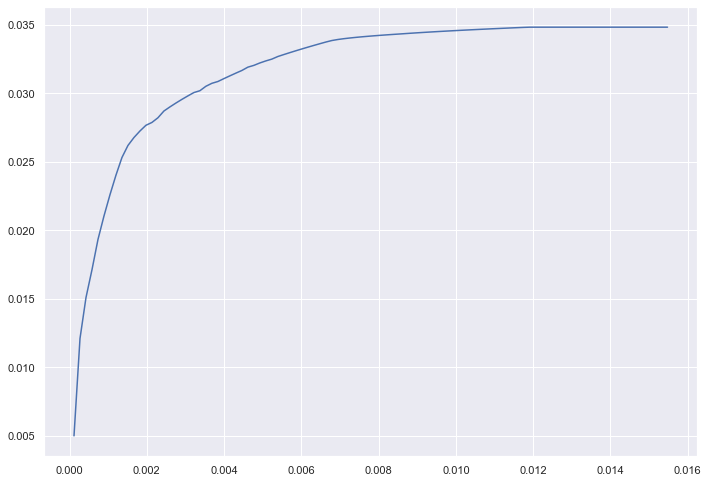

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x, y)